In [ ]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import pywt
import cv2
import time
import copy
import random
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import timm
import torch.optim as optim
from tqdm import tqdm

from torch.cuda.amp import autocast, GradScaler
from scipy.stats import ttest_ind, ks_2samp, uniform, randint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
main_path = '/kaggle/input/dataset-custom/dataset'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

# Exploratory Data Analysis (EDA) of the Dataset

Loading the dataset with background

In [3]:
# Paths to the real and fake classes in the train directory
real_class_dir = os.path.join(train_dir, 'real')
fake_class_dir = os.path.join(train_dir, 'fake')

# Define basic transformation for EDA
transform = transforms.Compose([
    transforms.Resize((224, 224)),
])

def load_images_from_class(class_dir, num_images=8000, transform=None):
    all_images = os.listdir(class_dir)
    sampled_images = random.sample(all_images, min(num_images, len(all_images)))
    images = []
    for img_name in sampled_images:
        img_path = os.path.join(class_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if transform:
            image = transform(image)
        images.append(np.array(image))
    return images

# Load images
real_images = load_images_from_class(real_class_dir, num_images=2000, transform=transform)
fake_images = load_images_from_class(fake_class_dir, num_images=2000, transform=transform)

# Convert lists to numpy arrays
real_images_array = np.array(real_images)
fake_images_array = np.array(fake_images)

## Computing Average and Superimposed faces from Real and Fake images

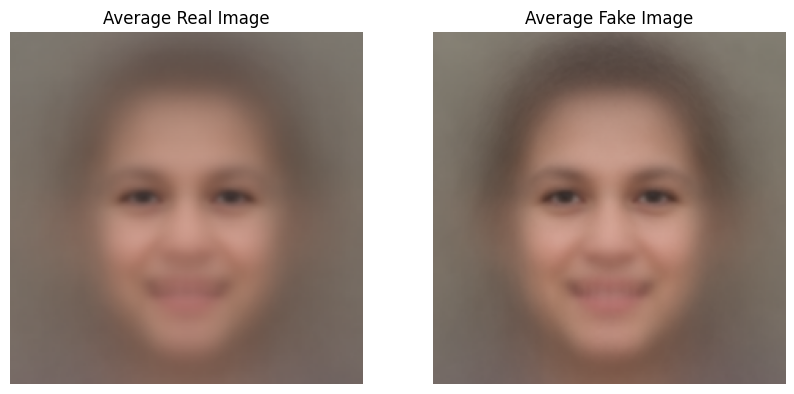

In [4]:
# Compute average images
real_avg_image = np.mean(real_images_array, axis=0)
fake_avg_image = np.mean(fake_images_array, axis=0)

# Display average images
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(real_avg_image.astype('uint8'))
plt.title('Average Real Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(fake_avg_image.astype('uint8'))
plt.title('Average Fake Image')
plt.axis('off')

plt.show()

## Color Histogram

For each of the red, green, and blue channels, we can compute the histogram of the pixel values. This will give us an idea of the distribution of pixel values for each channel for both real and fake images.

In [5]:
def compute_color_histograms(image, bins=256, return_features=True):
    """
    Compute color histograms for an image.
    :param image: numpy array of shape (H, W, 3)
    :param bins: number of bins for the histogram
    :param return_features: if True, return the concatenated histograms for all channels
    :return: color histograms
    """
    image_np = np.array(image)
    r, g, b = image_np[:, :, 0], image_np[:, :, 1], image_np[:, :, 2]
    hist_r, _ = np.histogram(r.flatten(), bins=bins, range=(0, 256))
    hist_g, _ = np.histogram(g.flatten(), bins=bins, range=(0, 256))
    hist_b, _ = np.histogram(b.flatten(), bins=bins, range=(0, 256))
    hist_r = hist_r / np.sum(hist_r)
    hist_g = hist_g / np.sum(hist_g)
    hist_b = hist_b / np.sum(hist_b)

    if return_features:
        return np.concatenate([hist_r, hist_g, hist_b])
    return hist_r,hist_g,hist_b

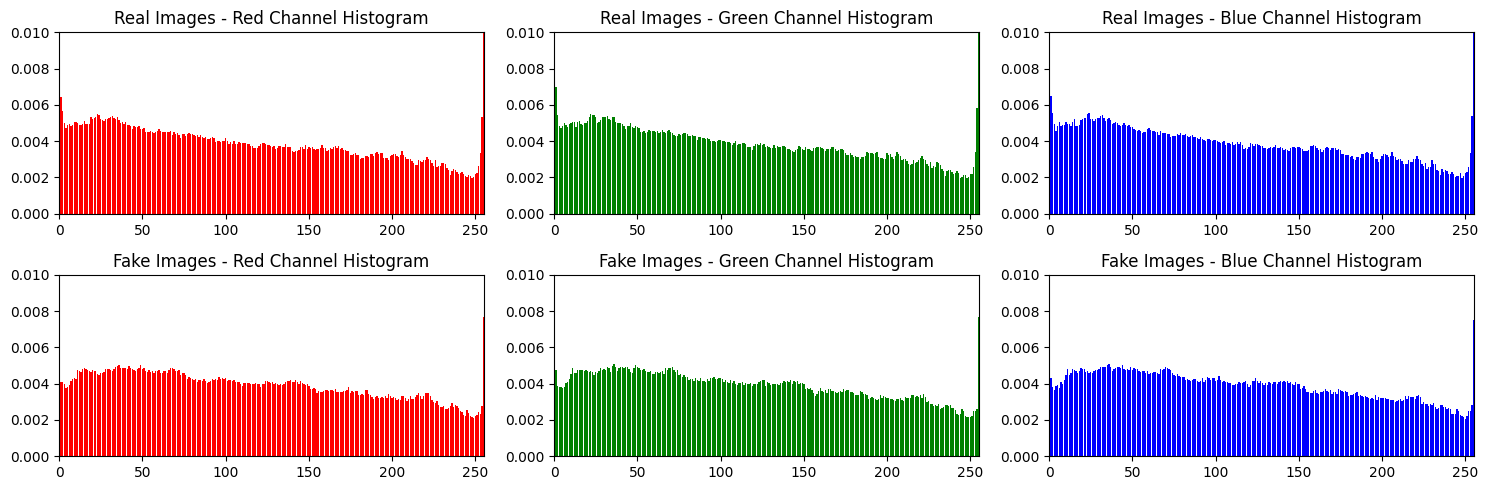

In [7]:
# Compute histograms
real_hist_r, real_hist_g, real_hist_b = compute_color_histograms(real_images_array, return_features=False)
fake_hist_r, fake_hist_g, fake_hist_b = compute_color_histograms(fake_images_array, return_features=False)

bins = np.arange(256)
plt.figure(figsize=(15,5))

plt.subplot(2,3,1)
plt.bar(bins, real_hist_r, color='r')
plt.title('Real Images - Red Channel Histogram')
plt.xlim([0,255])
plt.ylim([0,0.010])

plt.subplot(2,3,2)
plt.bar(bins, real_hist_g, color='g')
plt.title('Real Images - Green Channel Histogram')
plt.xlim([0,255])
plt.ylim([0,0.010])

plt.subplot(2,3,3)
plt.bar(bins, real_hist_b, color='b')
plt.title('Real Images - Blue Channel Histogram')
plt.xlim([0,255])
plt.ylim([0,0.010])

plt.subplot(2,3,4)
plt.bar(bins, fake_hist_r, color='r')
plt.title('Fake Images - Red Channel Histogram')
plt.xlim([0,255])
plt.ylim([0,0.010])

plt.subplot(2,3,5)
plt.bar(bins, fake_hist_g, color='g')
plt.title('Fake Images - Green Channel Histogram')
plt.xlim([0,255])
plt.ylim([0,0.010])

plt.subplot(2,3,6)
plt.bar(bins, fake_hist_b, color='b')
plt.title('Fake Images - Blue Channel Histogram')
plt.xlim([0,255])
plt.ylim([0,0.010])

plt.tight_layout()
plt.show()

Now, we will determine whether the color histograms of the real and fake images are different. For that we will use the Kolmogorov-Smirnov test.

In [8]:
statistic, p_value = ks_2samp(real_hist_r, fake_hist_r)
print(f'KS Statistic: {statistic}, P-value: {p_value}')

statistic, p_value = ks_2samp(real_hist_g, fake_hist_g)
print(f'KS Statistic: {statistic}, P-value: {p_value}')

statistic, p_value = ks_2samp(real_hist_b, fake_hist_b)
print(f'KS Statistic: {statistic}, P-value: {p_value}')

KS Statistic: 0.15625, P-value: 0.0038097429114247482
KS Statistic: 0.14453125, P-value: 0.009440529437020562
KS Statistic: 0.140625, P-value: 0.012573067259953767


We can see that all p-values are lower than $0.05$ for all the channels. This means that the difference in the color histograms of the real and fake images is statistically significant.

## Wavelet Decomposition

In [9]:
def compute_wavelet_energy(image, wavelet='db1', level=3, normalize=False):
    """
    Computes the wavelet energy at each decomposition level for a grayscale image.

    :param image: 2D numpy array representing the grayscale image.
    :param wavelet: Type of wavelet to use (e.g., 'db1', 'haar', 'sym2').
    :param level: Number of decomposition levels.

    :return energy: List of energies at each level.
    """
    
    # Perform multilevel 2D discrete wavelet transform
    coeffs = pywt.wavedec2(image, wavelet=wavelet, level=level)
    
    # Compute energy at each level (excluding the approximation coefficients)
    energy = []
    for detail_coeffs in coeffs[1:]:
        cH, cV, cD = detail_coeffs
        # Energy is the sum of squares of the coefficients
        level_energy = np.sum(cH**2) + np.sum(cV**2) + np.sum(cD**2)
        energy.append(level_energy)
        
    if normalize:
        energy = np.array(energy)
        energy /= np.sum(energy)
    return energy

/opt/conda/lib/python3.10/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


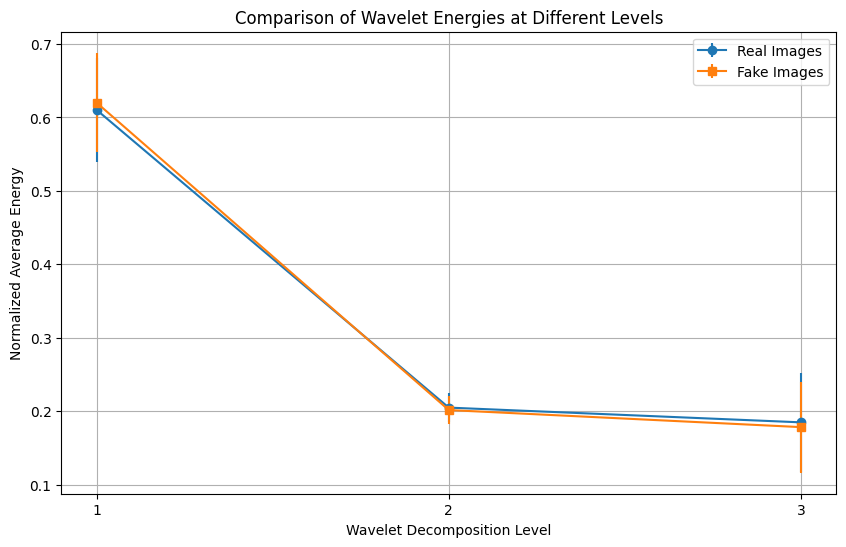

In [10]:
# Compute wavelet energies for real images
real_wavelet_energies = []
for image in real_images:
    energy = compute_wavelet_energy(image, wavelet='db2', level=3)
    real_wavelet_energies.append(energy)

# Compute wavelet energies for fake images
fake_wavelet_energies = []
for image in fake_images:
    energy = compute_wavelet_energy(image, wavelet='db2', level=3)
    fake_wavelet_energies.append(energy)

# Convert lists to numpy arrays
real_wavelet_energies = np.array(real_wavelet_energies)  # Shape: (num_images, levels)
fake_wavelet_energies = np.array(fake_wavelet_energies)

# Normalize energies by the total energy per image
real_total_energy = np.sum(real_wavelet_energies, axis=1, keepdims=True)
fake_total_energy = np.sum(fake_wavelet_energies, axis=1, keepdims=True)

real_wavelet_energies_norm = real_wavelet_energies / real_total_energy
fake_wavelet_energies_norm = fake_wavelet_energies / fake_total_energy

# Compute mean and standard deviation across images for each level
real_mean_energy = np.mean(real_wavelet_energies_norm, axis=0)
real_std_energy = np.std(real_wavelet_energies_norm, axis=0)

fake_mean_energy = np.mean(fake_wavelet_energies_norm, axis=0)
fake_std_energy = np.std(fake_wavelet_energies_norm, axis=0)

levels = np.arange(1, len(real_mean_energy) + 1)

plt.figure(figsize=(10, 6))
plt.errorbar(levels, real_mean_energy, yerr=real_std_energy, fmt='-o', label='Real Images')
plt.errorbar(levels, fake_mean_energy, yerr=fake_std_energy, fmt='-s', label='Fake Images')
plt.xlabel('Wavelet Decomposition Level')
plt.ylabel('Normalized Average Energy')
plt.title('Comparison of Wavelet Energies at Different Levels')
plt.xticks(levels)
plt.legend()
plt.grid(True)
plt.show()

Now again we will determine whether the wavelet decompositions of the real and fake images are statistically different. For that we will use the Student's t-test.

In [11]:
for i in range(len(real_mean_energy)):
    t_stat, p_value = ttest_ind(real_wavelet_energies_norm[:, i], fake_wavelet_energies_norm[:, i], equal_var=False)
    print(f'Level {i+1}: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}')

Level 1: t-statistic = -4.462, p-value = 0.000
Level 2: t-statistic = 5.393, p-value = 0.000
Level 3: t-statistic = 3.182, p-value = 0.001


For all the levels of the wavelet decomposition, we can see that the p-values are lower than $0.05$. This means that the difference in the wavelet decompositions of the real and fake images is statistically significant.

# ML Baseline: XG Boost

This model will be trained on both color histograms and wavelet decompositions of the images.

In [12]:
# Loading the dataset again

def load_image_paths_and_labels(class_dirs, num_images=1000):
    """
    Load image paths and labels from the specified class directories.
    :param class_dirs: dictionary mapping class names to directories
    :param num_images: maximum number of images to sample per class
    :return: list of image paths and corresponding labels
    """
    image_paths = []
    labels = []
    label_map = {'real': 0, 'fake': 1}
    for cls_name, cls_dir in class_dirs.items():
        all_images = os.listdir(cls_dir)
        sampled_images = random.sample(all_images, min(num_images, len(all_images)))
        paths = [os.path.join(cls_dir, img_name) for img_name in sampled_images]
        image_paths.extend(paths)
        labels.extend([label_map[cls_name]] * len(paths))
    return image_paths, labels

# Define class directories
class_dirs = {
    'real': real_class_dir,
    'fake': fake_class_dir
}

# Load image paths and labels
image_paths, labels = load_image_paths_and_labels(class_dirs, num_images=1000)

In [13]:
def extract_features(image_path):
    """
    Extracts features from an image.
    :param image_path: path to the image file
    :return: feature vector
    """
    
    # Load image
    image = Image.open(image_path).convert('RGB')
    image = image.resize((224, 224))

    # Compute RGB histograms
    hist_r, hist_g, hist_b = compute_color_histograms(image, return_features=False)
    hist_features = np.concatenate([hist_r, hist_g, hist_b])

    # Convert to grayscale
    image_gray = image.convert('L')
    image_array = np.array(image_gray)

    # Compute wavelet energies
    energies = compute_wavelet_energy(image_array, wavelet='db2', level=3)
    energies = np.array(energies)
    energies /= np.sum(energies)  # Normalize energies

    # Combine features
    features = np.concatenate([hist_features, energies])
    return features

In [14]:
# Extract features for all images
features_list = []
for path in image_paths:
    features = extract_features(path)
    features_list.append(features)

features_array = np.array(features_list)
labels_array = np.array(labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    features_array, labels_array, 
    test_size=0.2, random_state=42)

In [16]:
# Initialize the XGBClassifier
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 0.1),
    'reg_lambda': uniform(0.8, 0.4)
}

# # Initialize the XGBClassifier
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    objective='binary:logistic',
    n_jobs=-1
)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Best parameters
print(f'Best Parameters: {random_search.best_params_}')

# Best estimator
best_xgb_model = random_search.best_estimator_

After tuning the model hyperparameters we obtained the following best parameters:

```python
{'colsample_bytree': 0.7541666010159664, 'gamma': 0.007983126110107097, 'learning_rate': 0.0792681476866447, 'max_depth': 6, 'n_estimators': 160, 'reg_alpha': 0.06832635188254582, 'reg_lambda': 1.0439986631130485, 'subsample': 0.9332779646944658}
```

Final Model Evaluation:

In [17]:
# Make predictions on the test set
y_pred_optimized = best_xgb_model.predict(X_test)

# Compute accuracy
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f'Model Accuracy: {accuracy_optimized * 100:.2f}%')

# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred_optimized, target_names=['Real', 'Fake']))

# Confusion matrix
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
print('Confusion Matrix:')
print(cm_optimized)

# Deep Learning

After having established a baseline with XGBoost, we will now use a deep learning model to classify the images as real or fake.

## Dataset Definition

In [ ]:
class SubsetImageFolder(Dataset):

    def __init__(self, root_dir, transform=None, percentage=0.1):
        """
        Custom subset of the ImageFolder dataset.
        :param root_dir: root directory containing the image folders
        :param transform: image transform to apply
        :param percentage: percentage of images to sample from each class
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths, self.labels = [], []

        # List all subdirectories (classes)
        classes = sorted(os.listdir(root_dir))
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        # Collect image paths and their corresponding labels
        for cls_name in classes:
            cls_dir = os.path.join(root_dir, cls_name)
            if os.path.isdir(cls_dir):
                all_images = os.listdir(cls_dir)
                num_samples = int(len(all_images) * percentage)
                sampled_images = random.sample(all_images, num_samples)

                for img_name in sampled_images:
                    self.image_paths.append(os.path.join(cls_dir, img_name))
                    self.labels.append(class_to_idx[cls_name])

    def __len__(self):
        """
        Return the total number of samples in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Load an image and its label from the dataset.
        :param idx: index of the sample to load
        :return: image and label
        """
        img_path = self.image_paths[idx]
        # Load image for transformations
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        # Extract additional features before any transformations
        hist_features = compute_color_histograms(image)
        image_gray = image.convert('L')
        wavelet_features = compute_wavelet_energy(np.array(image_gray), normalize=True)

        # Convert features to tensors
        hist_features = torch.tensor(hist_features, dtype=torch.float32)
        wavelet_features = torch.tensor(wavelet_features, dtype=torch.float32)

        # Combine all additional features
        additional_features = torch.cat([hist_features, wavelet_features])

        if self.transform:
            image = self.transform(image=np.asarray(image))

        return image, additional_features, label

In [ ]:
# Define the transforms

transform = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.2),
    A.HueSaturationValue(p=0.3),
    A.ImageCompression(quality_lower=75, quality_upper=90, compression_type='jpeg', p=0.7),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.3),
    A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0), p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        A.ISONoise(p=0.5),
    ], p=0.3),
    ToTensorV2(),  # Ensure this is the last transform
])

transform_test = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [ ]:
# Create Datasets
train_dataset = SubsetImageFolder(root_dir=train_dir, transform=transform, percentage=0.5)
validation_dataset = SubsetImageFolder(root_dir=valid_dir, transform=transform_test, percentage=0.1)
test_dataset = SubsetImageFolder(root_dir=test_dir, transform=transform_test, percentage=0.5)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, 
    num_workers=8, pin_memory=True
)
validation_loader = DataLoader(
    validation_dataset, batch_size=128, shuffle=True, 
    num_workers=8, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=128, shuffle=False, 
    num_workers=8, pin_memory=True
)

## Model Definition

In [20]:
class MultiInputModel(nn.Module):
    
    def __init__(self, type='CNN', num_additional_features=None, freeze_layers=True):
        """
        Multi-input model that combines image and histogram features and wavelet energies.
        :param type: type of model to use ('CNN' or 'MLP')
        :param num_additional_features: number of additional features (histogram and wavelet energies)
        :param freeze_layers: if True, freeze the feature extractor layers
        """
        super(MultiInputModel, self).__init__()

        self.type = type
        if self.type == 'CNN':
            # Image processing branch (EfficientNetV2)
            self.feature_extractor = timm.create_model('efficientnetv2_rw_s.ra2_in1k', pretrained=True)
                    
            # Replace the classifier with an identity to extract features
            self.feature_extractor.classifier = nn.Identity()
            
            # Get the number of features from the feature extractor
            num_features = self.feature_extractor.num_features
            
            # Final classification layer for binary output
            self.classifier = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(num_features, 1)
            )
            
        else:
            # Feature processing branch (MLP)
            self.feature_extractor = nn.Sequential(
                nn.Linear(num_additional_features, 128),
                nn.ReLU(),
                nn.BatchNorm1d(128),
                nn.Dropout(0.5),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.BatchNorm1d(64),
                nn.Dropout(0.5),
            )
            self.classifier = nn.Linear(64, 1)

    def forward(self, image, additional_features):
        if self.type == 'CNN':
            x = self.feature_extractor(image)
        else:
            x = self.feature_extractor(additional_features)

        x = self.classifier(x)
        return x

In [ ]:
sample_image, sample_additional_features, _ = train_dataset[0]
num_additional_features = sample_additional_features.shape[0]

# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiInputModel(
    type='CNN',
    num_additional_features=None,
    freeze_layers=True
)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
scaler = torch.amp.GradScaler('cuda')

## Model Training

In [22]:
def train_epoch(model, loader, criterion, optimizer, device):
    """
    Train the model for one epoch.
    :param model: the model to train
    :param loader: the DataLoader for training data
    :param criterion: the loss function
    :param optimizer: the optimizer
    :param device: the device to train on
    :return: the epoch loss and accuracy
    """
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    for images, additional_features, labels in tqdm(loader, desc='Training', leave=False):
        images = images['image']
        images = images.to(device)
        additional_features = additional_features.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(images, additional_features)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        preds = torch.sigmoid(outputs) >= 0.5
        correct_preds += (preds == labels.byte()).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples
    return epoch_loss, epoch_acc


def validate_epoch(model, loader, criterion, device):
    """
    Validate the model for one epoch.
    :param model: the model to validate
    :param loader: the DataLoader for validation data
    :param criterion: the loss function
    :param device: the device to validate on
    :return: the epoch loss and accuracy
    """
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        for images, additional_features, labels in tqdm(loader, desc='Validation', leave=False):
            images = images['image']
            additional_features = additional_features.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images.cuda(), additional_features)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs) >= 0.5
            correct_preds += (preds == labels.byte()).sum().item()
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples
    return epoch_loss, epoch_acc

num_epochs = 5
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

early_stopping_patience = 5
no_improve_epochs = 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

    val_loss, val_acc = validate_epoch(model, validation_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        print('Best model saved.')
    else:
        no_improve_epochs += 1

    # Early stopping
    if no_improve_epochs >= early_stopping_patience:
        print('Early stopping due to no improvement in validation accuracy')
        break

    scheduler.step()

print('Training complete')
print(f'Best Validation Accuracy: {best_acc:.4f}')

Epoch 1/5
----------


Train Loss: 0.4758 Acc: 0.7569


Val Loss: 0.2856 Acc: 0.8892
Best model saved.
Epoch 2/5
----------


Train Loss: 0.2814 Acc: 0.8619


Val Loss: 0.1381 Acc: 0.9401
Best model saved.
Epoch 3/5
----------


Train Loss: 0.2197 Acc: 0.8875


Val Loss: 0.1226 Acc: 0.9592
Best model saved.
Epoch 4/5
----------


Train Loss: 0.1988 Acc: 0.8963


Val Loss: 0.1483 Acc: 0.9465
Epoch 5/5
----------


Train Loss: 0.1657 Acc: 0.9132


Val Loss: 0.0716 Acc: 0.9796
Best model saved.
Training complete
Best Validation Accuracy: 0.9796


In [23]:
# Load best model weights
model.load_state_dict(best_model_wts)

# Evaluate on test set
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

Test Loss: 0.0603 Acc: 0.9785


## Evaluation of Model on OOD Detection

In [24]:
def load_image(image_path):
    """
    Load an image from the specified path.
    :param image_path: path to the image file
    :return: the loaded image
    """
    image = Image.open(image_path).convert('RGB')  # Ensure it's in RGB format
    return image

def predict(image_path, model):
    """
    Perform prediction on a single image.
    :param image_path: path to the image file
    :param model: the trained model
    """
    
    # Load and transform the image
    image = load_image(image_path)
    transformed_image = transform_test(image=np.asarray(image))
    
    # Add a batch dimension (PyTorch models expect batch of images)
    input_tensor = transformed_image['image'].unsqueeze(0).cuda()  # Shape: [1, C, H, W]
    
    # Ensure model is in evaluation mode
    model.eval()
    
    # Perform prediction
    with torch.no_grad():
        output = model(input_tensor, [])  # Model output (logits)
    
    # Get the predicted class
    print('Real' if (torch.sigmoid(output) >= 0.5).item() == True else 'Fake')
    print(torch.sigmoid(output))

image_path = "/kaggle/input/picturos/4d0febed-22b1-4163-b78a-f84b1e4cf666.jpg"
predict(image_path, model)

image_path2 = "/kaggle/input/picturos-real/106967046-1635430835800-gettyimages-946971500-99821012.jpeg"
predict(image_path2, model)

image_path3 = "/kaggle/input/picturowski/yuck.png"
predict(image_path3, model)

Fake
tensor([[0.0022]], device='cuda:0')
Real
tensor([[0.8723]], device='cuda:0')
Fake
tensor([[0.0018]], device='cuda:0')


# Explainaibility

## SmoothGrad

In [25]:
def generate_smooth_grad(model, image, label, num_samples=100, noise_level=0.5):
    """
    Generate SmoothGrad saliency maps.
    
    :param model: The trained model.
    :param image: The input image tensor (1, 3, H, W).
    :param label: The ground truth label or the class index to visualize.
    :param num_samples: Number of noisy samples to generate.
    :param noise_level: The standard deviation of the Gaussian noise to add.
    
    :return smooth_grad: The SmoothGrad saliency map.
    """
    model.eval()
    image = image.clone().detach().to(next(model.parameters()).device).requires_grad_(True)
    smooth_grad = torch.zeros_like(image)

    for _ in range(num_samples):
        # Add random noise to the image
        noise = torch.randn_like(image) * noise_level
        noisy_image = image + noise
        noisy_image = noisy_image.clamp(0, 1)  # Ensure pixel values are in [0, 1]

        # Forward pass
        output = model(noisy_image, None)  # 'None' for additional features as it's not used in the CNN branch
        loss = F.binary_cross_entropy_with_logits(output, label.unsqueeze(0).float())

        # Backward pass to get gradients
        model.zero_grad()
        if image.grad is not None:
            image.grad.zero_()  # Zero the gradients of the image tensor
        loss.backward()
        grad = image.grad.data

        # Accumulate gradients
        smooth_grad += grad

    # Average over all samples
    smooth_grad /= num_samples
    # Compute the magnitude of the gradient for visualization
    smooth_grad = smooth_grad.abs().mean(dim=1, keepdim=True)  # Convert to grayscale
    return smooth_grad.squeeze().cpu().numpy()


def visualize_smooth_grad(image, smooth_grad, y_pred=None, y=None):
    """
    Visualize the SmoothGrad saliency map by overlaying it on the original image.
    
    :param image: The original image tensor (1, 3, H, W).
    :param smooth_grad: The SmoothGrad saliency map.
    :param y_pred: The predicted label (optional).
    :param y: The true label (optional).
    """
    image = denormalize(image, MEAN_IMAGE_NET, STD_IMAGE_NET)
    image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
    image_np = np.clip(image_np, 0, 1)

    # Normalize smooth_grad to range [0, 1] for visualization
    smooth_grad_normalized = (smooth_grad - smooth_grad.min()) / (smooth_grad.max() - smooth_grad.min())

    plt.figure(figsize=(6, 6))
    plt.imshow(image_np)
    plt.imshow(smooth_grad_normalized, cmap='hot', alpha=0.5)  # Overlay with transparency
    plt.axis('off')
    
    # Construct the title with optional prediction and true labels
    title = 'SmoothGrad Saliency Map'
    if y_pred:
        title += f'\nModel Prediction: {y_pred}'
    if y:
        title += f'\nTrue Label: {y}'
    plt.title(title, fontsize=10)
    plt.show()


def denormalize(image, mean, std):
    """
    Denormalize an image using the mean and standard deviation.
    
    :param image: The image tensor to denormalize.
    :param mean: The mean used for normalization.
    :param std: The standard deviation used for normalization.
    
    :return: The denormalized image tensor.
    """
    # Convert mean and std to tensors if they are not already
    if not isinstance(mean, torch.Tensor):
        mean = torch.tensor(mean, device=image.device)
    if not isinstance(std, torch.Tensor):
        std = torch.tensor(std, device=image.device)

    # Reshape mean and std to match image dimensions (C, H, W)
    mean = mean.view(-1, 1, 1)  # Reshape to (C, 1, 1) to match the channel size
    std = std.view(-1, 1, 1)    # Reshape to (C, 1, 1) to match the channel size

    # Apply the denormalization
    return image * std + mean


MEAN_IMAGE_NET = [0.485, 0.456, 0.406]
STD_IMAGE_NET = [0.229, 0.224, 0.225]

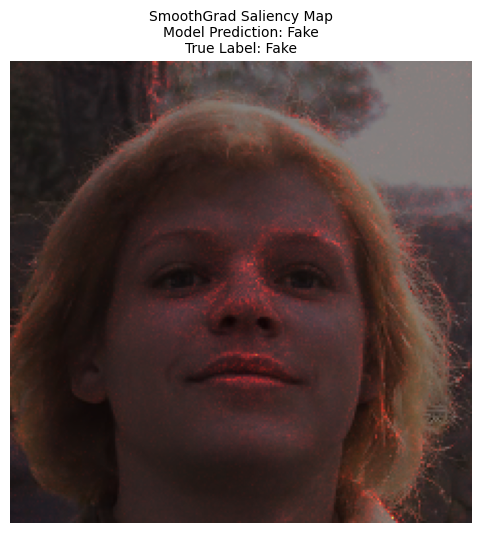

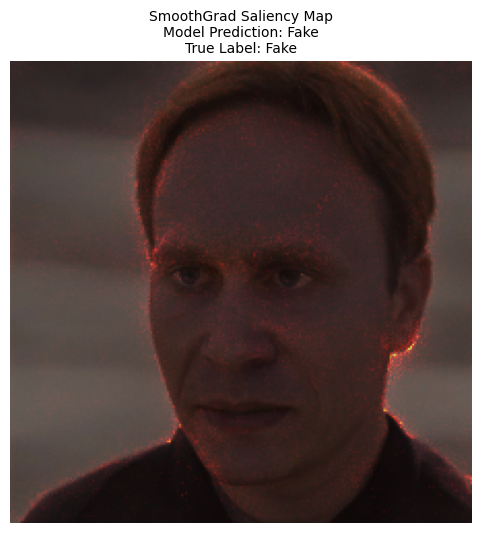

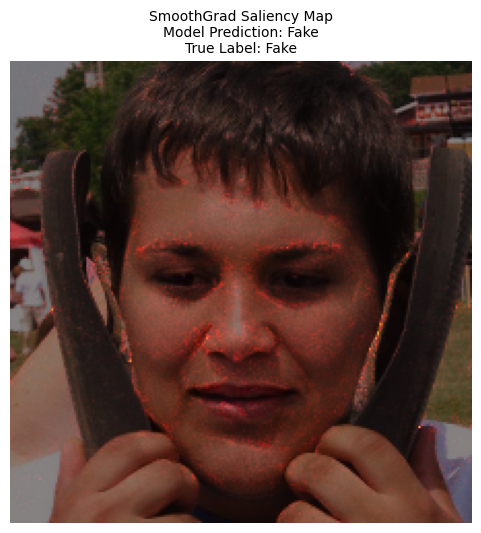

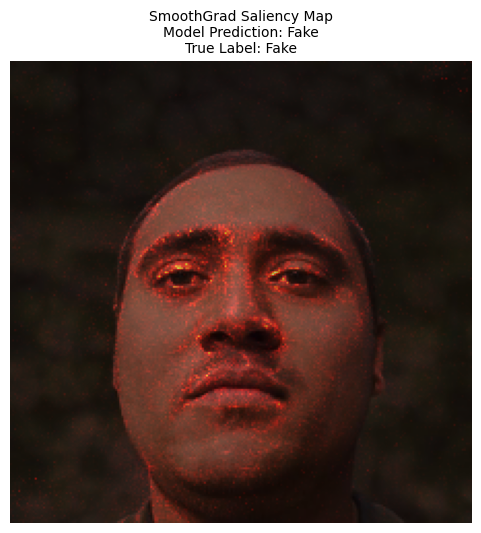

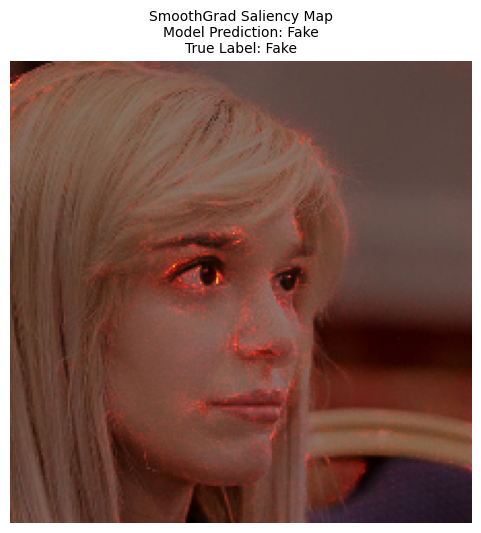

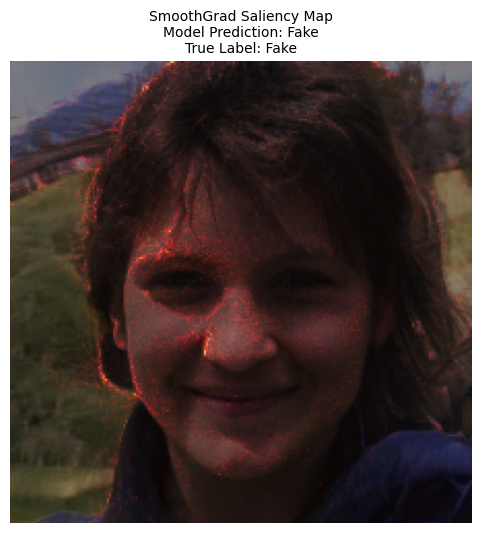

In [30]:
def get_sample_class(y):
    """
    Get the class label for a binary prediction.
    :param y: the binary prediction (0 or 1)
    :return: the class label ('Real' or 'Fake')
    """
    if not y or y == 0:
        return 'Fake'
    return 'Real'


# Show SmoothGrad on test images
for image_tensors, feature_tensors, label_tensors in test_loader:
    for i in range(6):
        image_tensor = image_tensors['image'][i].unsqueeze(0)
        label_tensor = label_tensors[i].unsqueeze(0)
        
        logits = model(image_tensor.cuda(), feature_tensors.cuda())
        binary_preds = torch.sigmoid(logits) >= 0.5
        
        # Get true and predicted labels
        y_pred_, y_ = binary_preds[0].item(), label_tensors[i].item()
        y_pred_, y_ = get_sample_class(y_pred_), get_sample_class(y_)
        
        smooth_grad = generate_smooth_grad(model, image_tensor.cuda(), label_tensor.cuda())
        visualize_smooth_grad(
            image_tensor.cpu(), smooth_grad, 
            y_pred=y_pred_, y=y_)
    break

SmoothGrad Saliency Maps for OOD Images

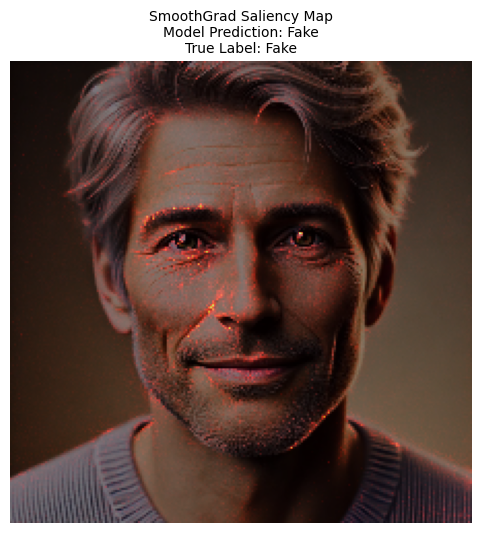

In [50]:
# Load an image
image_path = "/kaggle/input/picturos/4d0febed-22b1-4163-b78a-f84b1e4cf666.jpg"
image = np.asarray(Image.open(image_path).convert('RGB'))
image_tensor = transform_test(image=image)['image'].unsqueeze(0).to(device)
label = torch.tensor([0]).to(device)

smooth_grad = generate_smooth_grad(model, image_tensor, label, num_samples=100, noise_level=0.5)
with torch.no_grad():
    output = model(image_tensor, None)
    prob = torch.sigmoid(output).item()
    binary_pred = int(prob >= 0.5)
    y_pred = get_sample_class(binary_pred)

# Get the true label
y_true = get_sample_class(label.item())

# Visualize the saliency map
visualize_smooth_grad(
    image_tensor.cpu(), 
    smooth_grad, 
    y_pred=y_pred, 
    y=y_true
)

## GradCAM

In [37]:
class GradCAM:
    def __init__(self, model, target_layer):
        """
        :param model: the trained model
        :param target_layer: the target layer to visualize
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []

        # Register hooks to extract gradients and activations
        self._register_hooks()

    def _register_hooks(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        # Register hooks to the target layer
        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def generate_cam(self, input_image, target_class=None):
        # Forward pass
        output = self.model(input_image, None)
        if target_class is None:
            target_class = torch.argmax(output)

        # Backward pass
        self.model.zero_grad()
        output[:, target_class].backward()

        # Compute Grad-CAM
        gradients = self.gradients.detach().cpu().numpy()[0]
        activations = self.activations.detach().cpu().numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Apply ReLU to the CAM
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_image.shape[2], input_image.shape[3]))
        epsilon = 1e-8
        cam = (cam - cam.min()) / (cam.max() - cam.min() + epsilon)

        return cam

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

In [ ]:
def plot_grad_CAM_sample(cam, original_img, y_pred=None, y=None):
    """
    Plot the Grad-CAM saliency map overlayed on the original image.
    :param cam: the Grad-CAM saliency map
    :param original_img: the original image
    :param y_pred: the model prediction (optional)
    """
    original_img = denormalize(original_img, MEAN_IMAGE_NET, STD_IMAGE_NET)
    original_img = original_img.squeeze().permute(1, 2, 0).cpu().numpy()
    original_img = np.clip(original_img, 0, 1)

    # Convert the original image to grayscale
    original_img_gray = cv2.cvtColor((original_img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    original_img_gray = original_img_gray / 255.0  # Normalize to [0, 1]
    
    # Visualize the CAM
    plt.imshow(original_img_gray, cmap='bone', alpha=0.8)
    plt.imshow(cam, cmap='jet', alpha=0.15)
    plt.axis('off')
    plt.colorbar()

    title = ""
    title  = title + 'Model Prediction: ' + y_pred if y_pred else title
    title  = title + '\nTrue Label: ' + y if y else title
    plt.title(title)
    plt.show()

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


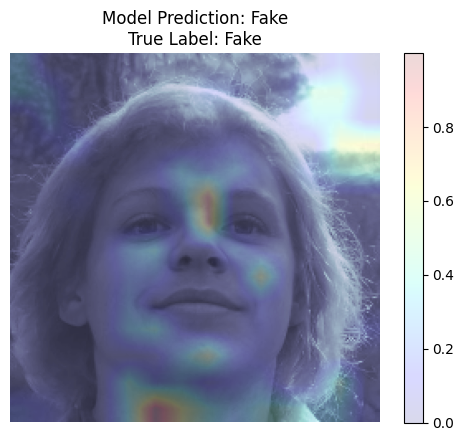

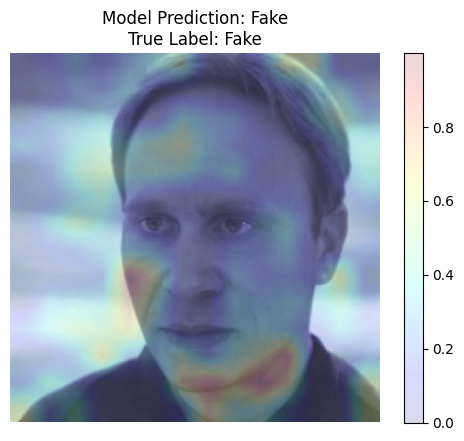

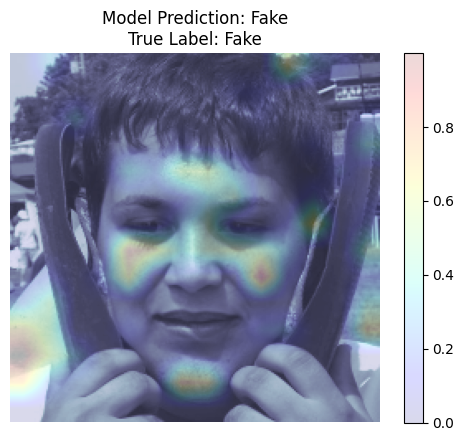

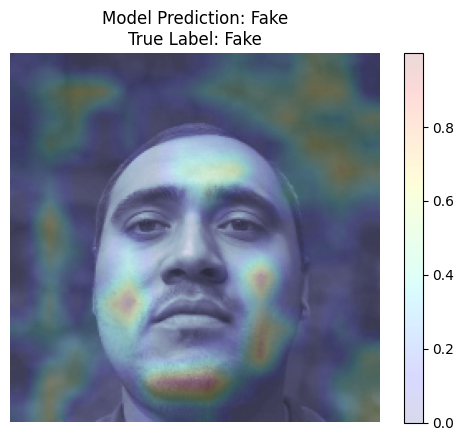

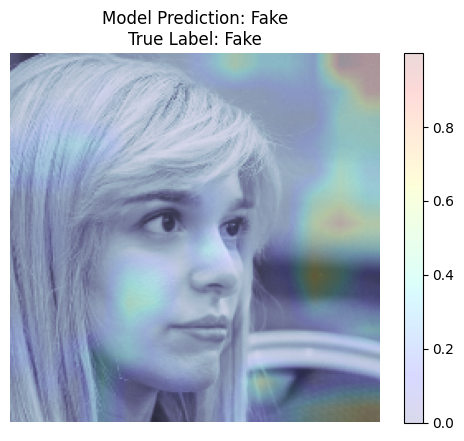

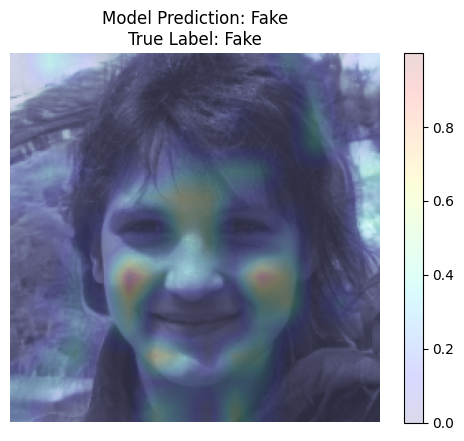

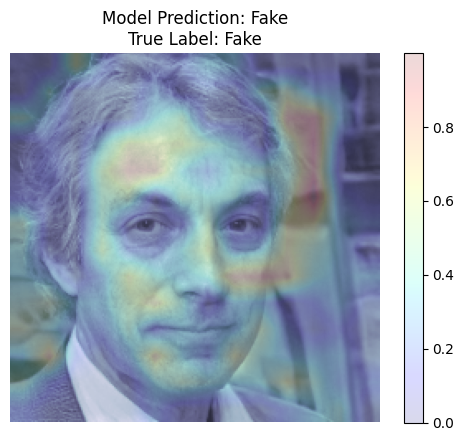

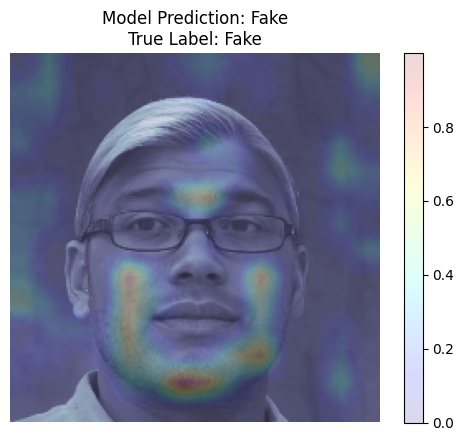

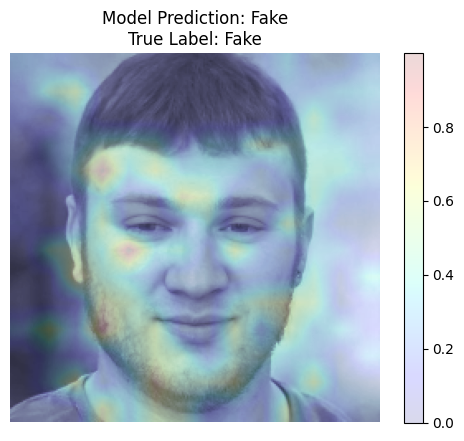

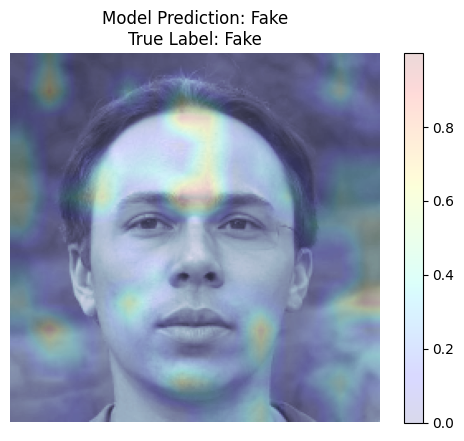

In [35]:
def plot_grad_CAM(grad_cam, num_images, type=None, true_label=None):
    """
    Plot Grad-CAM saliency maps for a sample of images in the test set.
    :param grad_cam: the GradCAM object
    :param num_images: number of images to plot
    :param type: type of images to plot ('correct', 'incorrect', or None)
    :param true_label: the true label of the images to plot
    """
    counter = 0
    
    for image_tensors, feature_tensors, label_tensors in test_loader:
        for i in range(image_tensors['image'].shape[0]):
            image_tensor = image_tensors['image'][i].unsqueeze(0)
            label_tensor = label_tensors[i].unsqueeze(0)
            
            logits = model(image_tensor.cuda(), feature_tensors.cuda())
            binary_preds = torch.sigmoid(logits) >= 0.5
            
            # Get true and predicted labels
            y_pred_, y_ = binary_preds[0].item(), label_tensors[i].item()
            y_pred_, y_ = get_sample_class(y_pred_), get_sample_class(y_)
            
            if not true_label or true_label == y_:
                if not type:
                    plot_grad_CAM_sample(
                        grad_cam.generate_cam(image_tensor.cuda()), 
                        image_tensor, y_pred_, y_)
                    counter +=1
                elif y_pred_ == y_ and type == 'correct':
                    plot_grad_CAM_sample(
                        grad_cam.generate_cam(image_tensor.cuda()), 
                        image_tensor, y_pred_, y_)
                    counter +=1
                elif y_pred_ != y_ and type == 'incorrect':
                    plot_grad_CAM_sample(
                        grad_cam.generate_cam(image_tensor.cuda()), 
                        image_tensor, y_pred_, y_)
                    counter +=1
        
                if counter >= num_images:      
                    return

# Last layer of the model
# target_layer = model.feature_extractor.conv_head
target_layer = model.feature_extractor.blocks[-2]
plot_grad_CAM(
    GradCAM(model, target_layer), 
    num_images=10, type='correct', true_label='Fake')